In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('classification-4.csv')
df = df.rename(columns={"target":"target_1"})

In [3]:
df_train,df_test = train_test_split(df, test_size=0.25,shuffle=False)

In [4]:
X_train = df_train.drop('target_1',axis=1).values
X_test = df_test.drop('target_1',axis=1).values

y_train = df_train['target_1']
y_test = df_test['target_1']

Plot of the test inputs.

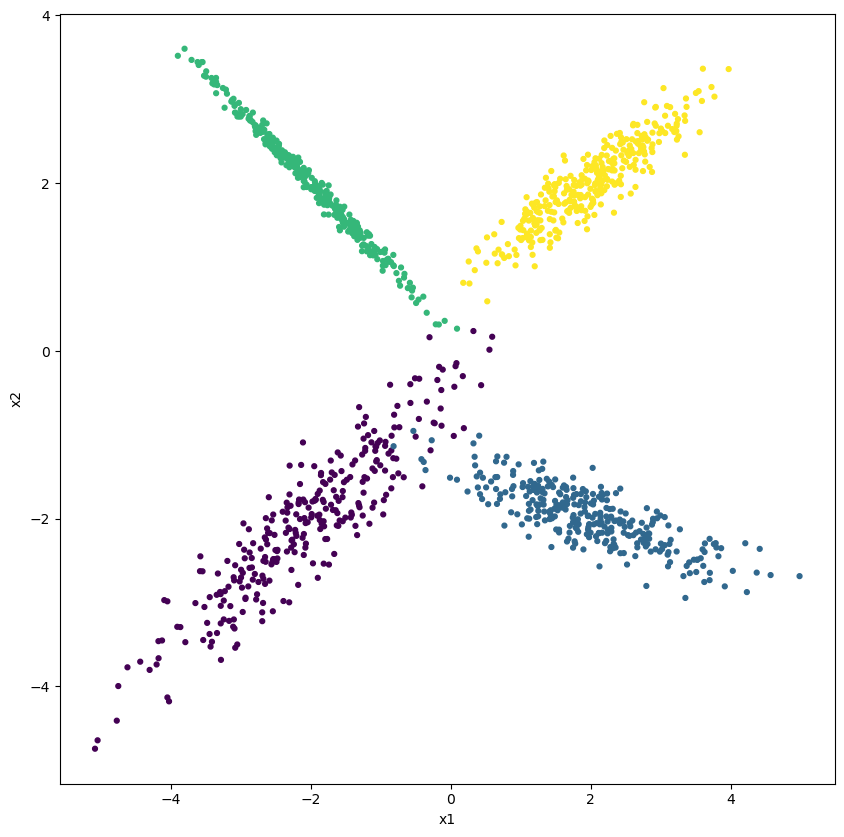

In [45]:
plt.figure(figsize=(10,10))
plt.scatter(df_test['feature_1'],df_test['feature_2'],s=12,c=df_test['target_1'],cmap="viridis")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

Separate and one-hot encode each class to get K=4 Binary Classes

In [6]:
def onehot(y):
    y = pd.DataFrame(y)
    y["target_1"] = y.iloc[:,0]
    y["target_2"] = y["target_1"]
    y["target_3"] = y["target_1"]
    y["target_4"] = y["target_1"]
    y["target_1"] = np.where(y["target_1"] == 1,1,0)
    y["target_2"] = np.where(y["target_2"] == 2,1,0)
    y["target_3"] = np.where(y["target_3"] == 3,1,0)
    y["target_4"] = np.where(y["target_4"] == 4,1,0)
    return y

y_train = onehot(y_train).values
y_test = onehot(y_test).values

We will use softmax and Leaky Relu activation functions.
For the error function we will use cross entropy loss:


$E(w) = - \sum_{n=1}^{N} \sum_{k=1}^{K} t_{kn} ln(y_k (x_n,w))$

for K = 4 binary classes

Architecture will be: 2-10-10-10-3
and we will use mini-batch sgd as an optimizer

In [7]:
def lrelu(x,alpha=0.01):
    return np.where(x>0,x,alpha*x)

def lrelu_d(x,alpha=0.01):
    return np.where(x>0,1,alpha)

def softmax(x):
    exp_x = np.exp(x-np.max(x,axis=1,keepdims=True))
    return exp_x / np.sum(exp_x,axis=1,keepdims=True)

Forward Prop

In [8]:
def forward(X,w1,w2,w3,w4):
    Xc = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    aj1 = Xc @ w1
    zj1 = lrelu(aj1)
    zj1c = np.concatenate([zj1, np.ones((zj1.shape[0], 1))], axis=1)
    ak2 = zj1c @ w2
    zk2 = lrelu(ak2)
    zk2c = np.concatenate([zk2, np.ones((zk2.shape[0], 1))], axis=1)
    al3 = zk2c @ w3
    zl3 = lrelu(al3)
    zl3c = np.concatenate([zl3, np.ones((zl3.shape[0], 1))], axis=1)
    an4 = zl3c @ w4
    yn4 = softmax(an4)
    return Xc,aj1,zj1c,ak2,zk2c,al3,zl3c,yn4 # [input, pre-act 1, act 1b, pre-act 2, act 2b, pre-act 3, act 3b, output]

Backprop

In [9]:
def backward(Xc, t, o, aj, zj, ak, zk, al, zl, w2, w3, w4):
    delta_4 = o - t #predicted output - target
    delta_3 = lrelu_d(al) * (delta_4 @ w4[:-1].T)
    delta_2 = lrelu_d(ak) * (delta_3 @ w3[:-1].T)
    delta_1 = lrelu_d(aj) * (delta_2 @ w2[:-1].T)

    dw4 = zl.T @ delta_4
    dw3 = zk.T @ delta_3
    dw2 = zj.T @ delta_2
    dw1 = Xc.T @ delta_1

    return dw4,dw3,dw2,dw1 # gradients of the error with respect to each weight

SGD function

In [10]:
def sgd(W,dw,eta):
    new_weights = []
    for W_i, dw_i in zip(W,dw):
        newW = W_i - eta*dw_i
        new_weights.append(newW)
    return new_weights

Weight Training + Loss

In [11]:
def train_mini_batch(X,t,eta,epochs,batch_size):
    w1 = np.random.randn(X.shape[1]+1, 10)
    w2 = np.random.randn(10+1,10)
    w3 = np.random.randn(10+1,10)
    w4 = np.random.randn(10+1,4)

    #t = t.reshape(-1,1) #do if needed
    N = X.shape[0]

    for epoch in range(epochs):
        indices = np.arange(N)
        np.random.shuffle(indices)
        X = X[indices]
        t = t[indices]

        for i in range(0,N,batch_size):
            X_batch = X[i:i+batch_size]
            t_batch = t[i:i+batch_size]

            Xc, aj1, zj1c, ak2, zk2c, al3, zl3c, yn4 = forward(X_batch, w1, w2, w3, w4)
            dw4,dw3,dw2,dw1 = backward(Xc, t_batch, yn4, aj1, zj1c, ak2, zk2c, al3, zl3c, w2, w3, w4)
            w1,w2,w3,w4 = sgd([w1,w2,w3,w4],[dw1,dw2,dw3,dw4],eta)
        if epoch % 1000 == 0:
            _,_,_,_,_,_,_,yn4_full = forward(X,w1,w2,w3,w4)
            eps = 1e-8
            loss = -np.mean(np.sum(t * np.log(yn4_full + eps), axis=1))
            print(f"Epoch {epoch}: Loss = {loss:.6f}, z3 mean = {np.mean(yn4_full):.4f}")
    return yn4_full,w1,w2,w3,w4

_,w1,w2,w3,w4 = train_mini_batch(X_train, y_train, 0.001, 6500, 32)
_,_,_,_,_,_,_,yn4_test = forward(X_test, w1, w2, w3, w4)
y_pred = (yn4_test > 0.5).astype(int)
            

Epoch 0: Loss = 0.067569, z3 mean = 0.2500
Epoch 1000: Loss = 0.012538, z3 mean = 0.2500
Epoch 2000: Loss = 0.010889, z3 mean = 0.2500
Epoch 3000: Loss = 0.009470, z3 mean = 0.2500
Epoch 4000: Loss = 0.009328, z3 mean = 0.2500
Epoch 5000: Loss = 0.007286, z3 mean = 0.2500
Epoch 6000: Loss = 0.006350, z3 mean = 0.2500


Scoring Predicitions

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#compares predictions with test target values and scores them

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("accuracy: ", accuracy)
print("precision: ",precision)
print("recall", recall)
print("f1:", f1)

accuracy:  0.992
precision:  0.9917808892792861
recall 0.9916840780492316
f1: 0.9917258474512749


Graphing the Decision Boundaries:

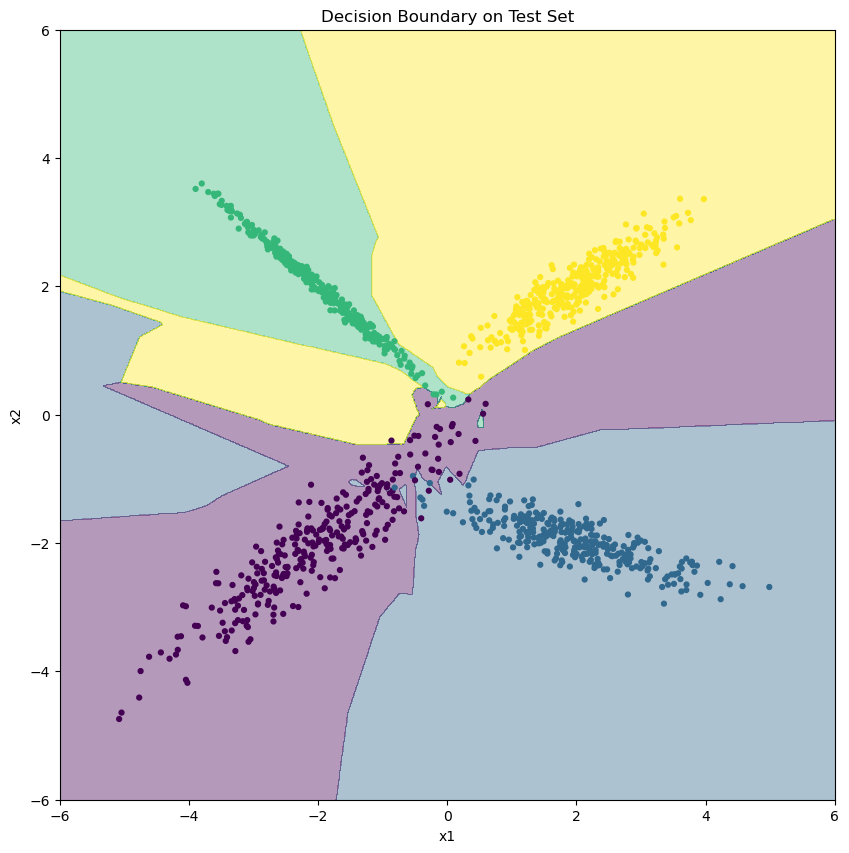

In [54]:
#Creating a grid over the feature space
h = 0.01

x_min, x_max = -6, 6
y_min, y_max = -6, 6
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

#Predicting class for each point in the grid

grid = np.c_[xx.ravel(), yy.ravel()]
_, _, _, _, _, _, _, yn4_grid = forward(grid, w1, w2, w3,w4)
Z = np.argmax(yn4_grid, axis=1).reshape(xx.shape)

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(["#440154", "#31688e", "#35b779", "#fde725"])  # dark purple, blue, green, yellow

# Plot decision boundary
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.4)

# Scatter test points using the same custom color map
plt.scatter(X_test[:, 0], X_test[:, 1], c=np.argmax(y_test, axis=1), cmap=custom_cmap, s=12)
plt.title("Decision Boundary on Test Set")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

The model is extremely accurate and only misclassifies a few points. However, the model is very slow.

In [53]:
print(yn4_test)

[[1.84874172e-071 6.66835010e-088 4.09431219e-028 1.00000000e+000]
 [6.90207599e-051 1.00000000e+000 1.41189823e-073 4.43737599e-076]
 [9.79488217e-001 2.05117828e-002 1.50618596e-013 3.89438923e-011]
 ...
 [1.00000000e+000 3.26374758e-021 1.90126647e-109 1.13632281e-046]
 [9.70793052e-043 1.00000000e+000 1.02240177e-066 4.00061831e-068]
 [9.99877801e-001 9.26865867e-005 8.67697097e-029 2.95127594e-005]]
